In [73]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy import integrate

import pandas as pd

In [74]:
# Backend set up for neural networks
torch.cuda.empty_cache()
# Set seed
seed = 123
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.set_default_dtype(torch.float32)


# CUDA if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [75]:
# MLP with attention
class MLP(nn.Module):
    def __init__(self, layers=[2,40,40,40,1], activation="tanh"):
        super().__init__()
        self.length = len(layers)
        self.activation = self._get_activation(activation)
        self.layers = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers) - 1)])
        self.attention_U = nn.Linear(layers[0], layers[1])
        self.attention_V = nn.Linear(layers[0], layers[1])
        self.apply(self._initialize_weights)
    
    def forward(self, x, t):
        if not torch.is_tensor(x):
            x = torch.from_numpy(x).float().to(device)
        if not torch.is_tensor(t):
            t = torch.from_numpy(t).float().to(device)
        
        input = torch.cat([x,t], dim=1)
        output = self.activation(self.layers[0](input))
        U = self.activation(self.attention_U(input))
        V = self.activation(self.attention_V(input))
        output = output*U + (1-output)*V
        
        for i in range(1, self.length - 2):
            output = self.activation(self.layers[i](output))
            output = output * U + (1 - output) * V

        return self.layers[-1](output)


    @staticmethod 
    def _get_activation(activation):
        if activation.lower() == "tanh":
            return nn.Tanh()
        elif activation.lower() == "relu":
            return nn.ReLU()
        else:
            return nn.ReLU

    @staticmethod 
    def _initialize_weights(self):
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_normal_(module.weight)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0.0) 

In [96]:
class Burgers_AV_PINN(nn.Module):
    def __init__(self, layers=[2,40,40,40,40,1], activation="ReLU", nu=0.001, weight_threshold=1000):
        super().__init__()
        self.model = MLP(layers, activation)
        self.nu = nu

        self.weight_threshold = weight_threshold
        self.sigma_r = nn.Parameter(torch.tensor([1.0], requires_grad=True, device=device).float())
        self.sigma_ic = nn.Parameter(torch.tensor([1.0], requires_grad=True, device=device).float())
        self.sigma_bc = nn.Parameter(torch.tensor([1.0], requires_grad=True, device=device).float())


        # Learnable artificial viscocity parameters
        self.nu_max = nn.Parameter(torch.tensor(0.0))
        self.w_nu = 0.1

        # Training tracker
        self.history = {"total_loss": [], "MSE":[], "residual_loss": [], "initial_loss": [], "boundary_loss": []}

    
    def forward(self, x, t):
        return self.model(x, t)
    
    def av(self, x):
        return torch.exp(-x**2 / (2 * self.w_nu**2))
    
    def burgers_residual(self, x, t):

        # Create tensors that require gradients
        x = x.clone().detach().requires_grad_(True)
        t = t.clone().detach().requires_grad_(True)

        # Forward pass
        u = self.model.forward(x,t)

        # Gradients
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True, only_inputs=True)[0]
        
        u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True, only_inputs=True)[0]
        
        u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True, only_inputs=True)[0]

        # Artificial viscocity
        nu = self.nu + (self.nu_max * self.av(x))

        # Plug gradients into Burgers equation for adaptive residual
        return u_t + u * u_x - nu*u_xx
    
    def adaptive_loss(self, r_loss, ic_loss, bc_loss):
        ic_adaptive_loss = ic_loss/(self.sigma_ic**2 + self.weight_threshold**-1)
        bc_adaptive_loss = bc_loss/(self.sigma_bc**2 + self.weight_threshold**-1)
        r_adaptive_loss =  r_loss/(self.sigma_r**2 + self.weight_threshold**-1)
        
        ic_adaptive_reg = torch.log(self.sigma_ic**2 + self.weight_threshold**-1) 
        bc_adaptive_reg = torch.log(self.sigma_bc**2 + self.weight_threshold**-1) 
        r_adaptive_reg = torch.log(self.sigma_r**2 + self.weight_threshold**-1)
        
        nu_adaptive_reg = torch.log(self.nu_max**2 + self.weight_threshold**-1)

        return 20*(ic_adaptive_loss + ic_adaptive_reg) + 20*(bc_adaptive_loss + bc_adaptive_reg) + 2*(r_adaptive_loss +  r_adaptive_reg) + 400 * (self.nu_max**2) + 0.001*nu_adaptive_reg
    
    def train_model(self, x_bounds, t_bounds, boundary_conditions, epochs=5000, lr=0.001,
          collocation_points=2000, initial_points=2000, boundary_points=2000):
        
        # Setting up optimizer
        optimizer = optim.Adam([
            {'params': self.model.parameters()},
            {'params': [self.nu_max], 'lr': lr * 0.8}  # Slower learning for AV param
        ], lr=lr)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=50, factor=0.5)

        # Setting up domain
        x_min, x_max = x_bounds
        t_min, t_max = t_bounds

        # Parameter for saving best-model (smallest mse)
        best_mse = 100

        for epoch in range(epochs):

            # Zero out optimizer
            optimizer.zero_grad()

            # Sampling on domain
            x_colloctions = torch.rand(collocation_points, 1, device=device) * (x_max - x_min) + x_min
            t_collocations = torch.rand(collocation_points, 1, device=device) * (t_max - t_min) + t_min
            
            x_initial = torch.rand(initial_points, 1, device=device) * (x_max - x_min) + x_min
            t_initial = torch.zeros(initial_points, 1, device=device)
            
            x_boundary_left = torch.ones(boundary_points, 1, device=device) * x_min
            x_boundary_right = torch.ones(boundary_points, 1, device=device) * x_max
            t_boundary = torch.rand(boundary_points, 1, device=device) * (t_max - t_min) + t_min

            # Calculate loss
            residual = self.burgers_residual(x_colloctions, t_collocations)
            residual_loss = torch.mean(residual**2)
            
            ic_pred = self.model(x_initial, t_initial)
            ic_true = boundary_conditions["initial_condition"](x_initial)
            ic_loss = torch.mean((ic_pred - ic_true)**2)
            
            boundary_left_pred = self.model(x_boundary_left, t_boundary)
            boundary_right_pred = self.model(x_boundary_right, t_boundary)
            boundary_left_true = boundary_conditions["boundary_left"](t_boundary)
            boundary_right_true = boundary_conditions["boundary_right"](t_boundary)
            boundary_loss = torch.mean((boundary_left_pred - boundary_left_true)**2) + torch.mean(( boundary_right_pred - boundary_right_true)**2)

            nu_loss = torch.mean(torch.square(self.nu_max - self.nu))

            #loss = 2*residual_loss + 20 * (ic_loss + boundary_loss) + 200 * (self.nu_max**2)
            loss = self.adaptive_loss(r_loss=residual_loss, ic_loss=ic_loss, bc_loss=boundary_loss)

            # Calculate MSE to save the model with the smallest value (early stopping)
            mse = residual_loss + ic_loss + boundary_loss + nu_loss
            if (mse < best_mse):
                best_mse = mse
                burgers_pinn_model_path = "burgers-av-pinn.pth"
                torch.save(self.state_dict(), burgers_pinn_model_path)

            # Backpropagate and update optimizer
            loss.backward()
            optimizer.step()
            scheduler.step(loss)

            # Appending loss and MSE data to history
            self.history["total_loss"].append(loss.item())
            self.history["residual_loss"].append(residual_loss.item())
            self.history["initial_loss"].append(ic_loss.item())
            self.history["boundary_loss"].append(boundary_loss.item())
            self.history["MSE"].append(mse.item())

            # Printing training progress
            if epoch % 500 == 0:
                print(f"Epoch {epoch}, Total Loss: {loss.item():.6f}, "
                    f"Residual Loss: {residual_loss.item():.6f}, "
                    f"Initial Loss: {ic_loss.item():.6f}, "
                    f"Boundary Loss: {boundary_loss.item():.6f}, "
                    f"MSE: {mse.item():.6f}, "
                    f"nu_max: {self.nu_max.item():.6f}")

In [97]:
# Setting up initial and boundary conditions
def initial_condition(x):
    return -torch.sin(np.pi * x)
    
def boundary_left(t):
    return torch.zeros_like(t)
    
def boundary_right(t):
    return torch.zeros_like(t)
    
boundary_conditions = {
    "initial_condition": initial_condition,
    "boundary_left": boundary_left,
    "boundary_right": boundary_right
}

# Initialize model and train
model = Burgers_AV_PINN(layers=[2,64,64,64,64,64,1], activation="tanh", nu=0.001).to(device)
model.train()
model.train_model(
    x_bounds=[-1,1], 
    t_bounds=[0,1], 
    boundary_conditions=boundary_conditions, 
    epochs=4001, 
    lr=0.02,
    collocation_points=5000, 
    initial_points=1000, 
    boundary_points=1000
)

Epoch 0, Total Loss: 11.041070, Residual Loss: 0.053198, Initial Loss: 0.468497, Boundary Loss: 0.077033, MSE: 0.598729, nu_max: 0.016000
Epoch 500, Total Loss: 0.058486, Residual Loss: 0.003633, Initial Loss: 0.000042, Boundary Loss: 0.000025, MSE: 0.003726, nu_max: 0.006499
Epoch 1000, Total Loss: 0.045622, Residual Loss: 0.001397, Initial Loss: 0.000008, Boundary Loss: 0.000001, MSE: 0.001417, nu_max: 0.004338
Epoch 1500, Total Loss: 0.041938, Residual Loss: 0.000944, Initial Loss: 0.000006, Boundary Loss: 0.000001, MSE: 0.000957, nu_max: 0.003479
Epoch 2000, Total Loss: 0.040260, Residual Loss: 0.000613, Initial Loss: 0.000004, Boundary Loss: 0.000001, MSE: 0.000623, nu_max: 0.003101
Epoch 2500, Total Loss: 0.040026, Residual Loss: 0.000607, Initial Loss: 0.000004, Boundary Loss: 0.000000, MSE: 0.000616, nu_max: 0.003015
Epoch 3000, Total Loss: 0.039972, Residual Loss: 0.000582, Initial Loss: 0.000004, Boundary Loss: 0.000000, MSE: 0.000590, nu_max: 0.003015
Epoch 3500, Total Loss:

In [98]:
def plot(model, x_bounds, t_bounds, x_plot_pts, t_plot_pts, analytical_data_path):

    # Setting up mesh grids
    x_min, x_max = x_bounds
    t_min, t_max = t_bounds

    x = torch.linspace(x_min, x_max, x_plot_pts).reshape(-1, 1)
    t = torch.linspace(t_min, t_max, t_plot_pts).reshape(-1, 1)
    
    X, T = torch.meshgrid(x.squeeze(), t.squeeze(), indexing='ij')

    X_flat = X.reshape(-1, 1)
    T_flat = T.reshape(-1, 1)
    
    # Predict solutions
    with torch.no_grad():
        U_pred = model(X_flat, T_flat).to("cpu")
    
    U_pred = U_pred.reshape(x_plot_pts, t_plot_pts)

    # Plotting the time-evolution as 3d graph
    fig = plt.figure(figsize=(15, 10))
    ax1 = fig.add_subplot(221, projection='3d')
    ax1.plot_surface(X.numpy(), T.numpy(), U_pred.numpy(), cmap="viridis")
    ax1.set_xlabel('x')
    ax1.set_ylabel('t')
    ax1.set_zlabel('u(x,t)')
    ax1.set_title('PINN Solution')

    # Plotting time slices at specific t values
    ax2 = fig.add_subplot(222)
    t_slices = [0, 0.25, 0.5, 0.75, 1]
    colors = ['b', 'g', 'r', 'c', 'm']
    
    for t_val, color in zip(t_slices, colors):
        # Find the closest time index
        t_idx = np.argmin(np.abs(t.squeeze().numpy() - t_val))
        ax2.plot(x.squeeze().numpy(), U_pred[:, t_idx].numpy(), 
                color=color, label=f't = {t_val:.2f}')
    
    ax2.set_xlabel('x')
    ax2.set_ylabel('u(x,t)')
    ax2.set_title('Time Slices of PINN Solution')
    ax2.legend()

    # Plotting the analytical solution (with time-evolution)
    try:
        u_analytical = pd.read_csv(analytical_data_path, delimiter="  ", header=None, engine="python")
    except:
        print(f"Could not load exact solution:")
        
    ax3 = fig.add_subplot(223, projection='3d')
    ax3.plot_surface(X.numpy(), T.numpy(), u_analytical, cmap="viridis")
    ax3.set_xlabel('x')
    ax3.set_ylabel('t')
    ax3.set_zlabel('u(x,t)')
    ax3.set_title("Analytical Solution")

    # Plot the difference with analytical solution
    error = np.abs(U_pred.numpy() - u_analytical)
    np.savetxt("error.csv", error, delimiter=',')

    ax4 = fig.add_subplot(224)
    fig.colorbar(ax4.pcolormesh(X.numpy(), T.numpy(), error, cmap="jet"))
    ax4.set_xlabel('x')
    ax4.set_ylabel('t')
    ax4.set_title(f"Point-wise error. Max: {np.max(error):.6f}")

    

    plt.tight_layout()
    plt.savefig('burgers_pinn_solution.png')
    plt.show()

    print(f"Mean Absolute error:  {np.mean(error):.6f}")

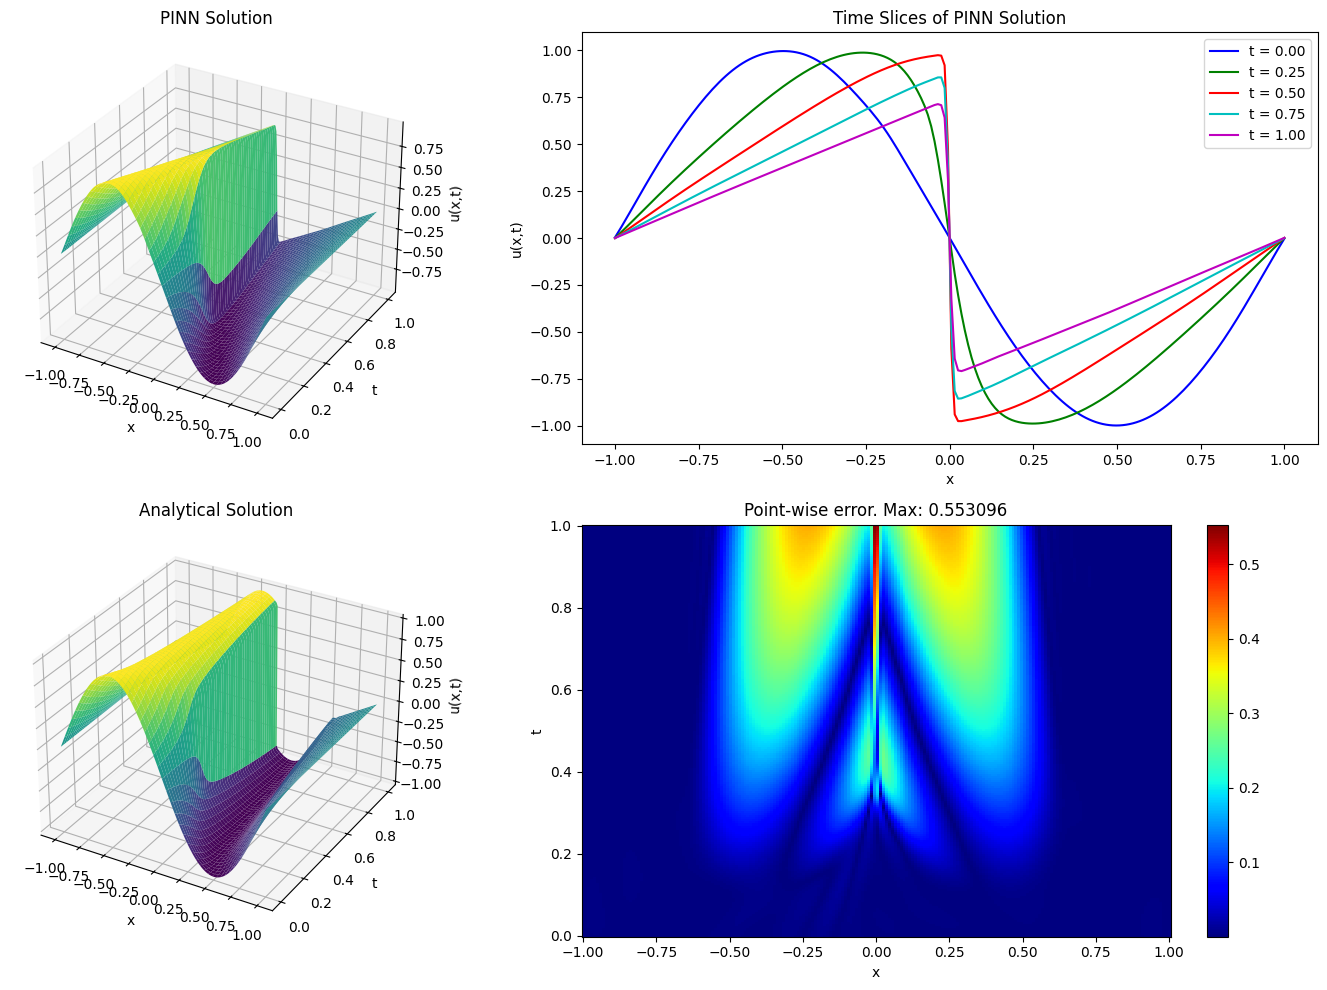

Mean Absolute error:  0.075745


In [99]:
# Comparing the model's prediction to best-possible analytical solution
model.load_state_dict(torch.load("burgers-av-pinn.pth"))
model.eval()
model.to("cpu")
plot(
    model=model,
    x_bounds=[-1,1],
    t_bounds=[0,1],
    x_plot_pts=200,
    t_plot_pts=200,
    analytical_data_path="burgers-analytical/burgers_solution_200_200.txt"
)